In [2]:
from google.colab import files
uploaded = files.upload()

Saving cookie_cats.csv to cookie_cats (2).csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from scipy.stats import chi2_contingency
import shap
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("cookie_cats.csv")

In [5]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [6]:
# Check types and missing values
print(df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Missing values:
 userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


In [7]:
# Encode version (gate_30 = 0, gate_40 = 1)
df['version_encoded'] = df['version'].map({'gate_30': 0, 'gate_40': 1})

# Convert target to binary (if not already)
df['retention_7'] = df['retention_7'].astype(int)
df['retention_1'] = df['retention_1'].astype(int)

# Optional sanity check
print(df[['version', 'version_encoded', 'retention_7']].head())

   version  version_encoded  retention_7
0  gate_30                0            0
1  gate_30                0            0
2  gate_40                1            0
3  gate_40                1            0
4  gate_40                1            1


In [8]:
df.shape

(90189, 6)

In [11]:
X = df[['sum_gamerounds', 'version_encoded']]
y = df['retention_7']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

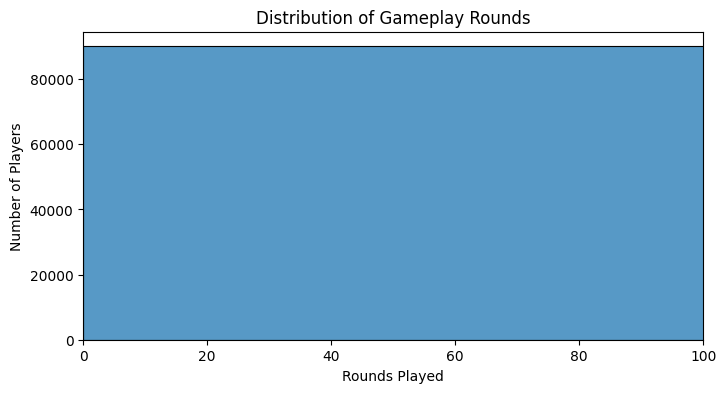

In [12]:
# Distribution of gamerounds
plt.figure(figsize=(8,4))
sns.histplot(df['sum_gamerounds'], bins=50, kde=False)
plt.title("Distribution of Gameplay Rounds")
plt.xlabel("Rounds Played")
plt.ylabel("Number of Players")
plt.xlim(0, 100)
plt.show()

In [13]:
# Retention rate by engagement bins
df['engagement_bin'] = pd.cut(df['sum_gamerounds'], bins=[0, 5, 20, 50, 1000], labels=['<5', '5-20', '20-50', '50+'])
ret_bin = df.groupby(['engagement_bin', 'version_encoded'])['retention_7'].mean().reset_index()

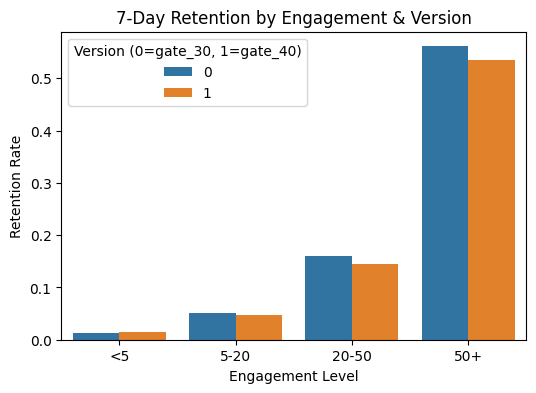

In [14]:
plt.figure(figsize=(6,4))
sns.barplot(x='engagement_bin', y='retention_7', hue='version_encoded', data=ret_bin)
plt.title("7-Day Retention by Engagement & Version")
plt.ylabel("Retention Rate")
plt.xlabel("Engagement Level")
plt.legend(title="Version (0=gate_30, 1=gate_40)")
plt.show()

In [15]:
# Contingency Table
ab_table = pd.crosstab(df['version_encoded'], df['retention_7'])
chi2, pval, _, _ = chi2_contingency(ab_table)

print("A/B Test on 7-Day Retention")
print("Chi-Square Test P-Value:", pval)
if pval < 0.05:
    print("Statistically significant difference between gate_30 and gate_40")
else:
    print("No statistically significant difference")

A/B Test on 7-Day Retention
Chi-Square Test P-Value: 0.0016005742679058301
Statistically significant difference between gate_30 and gate_40


In [16]:
# XGBoost Classifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

# Evaluate
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("XGBoost Performance:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

XGBoost Performance:
               precision    recall  f1-score   support

           0       0.89      0.95      0.92     14682
           1       0.71      0.51      0.59      3356

    accuracy                           0.87     18038
   macro avg       0.80      0.73      0.76     18038
weighted avg       0.86      0.87      0.86     18038

ROC AUC Score: 0.8855267629242524


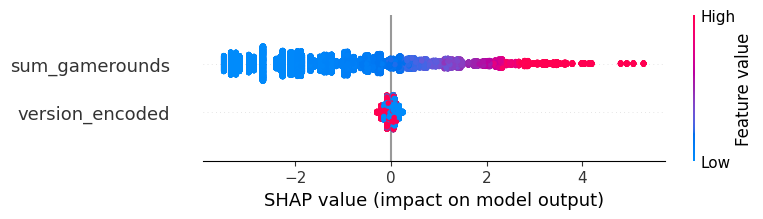

In [18]:
# SHAP on XGBoost
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, plot_type="dot")

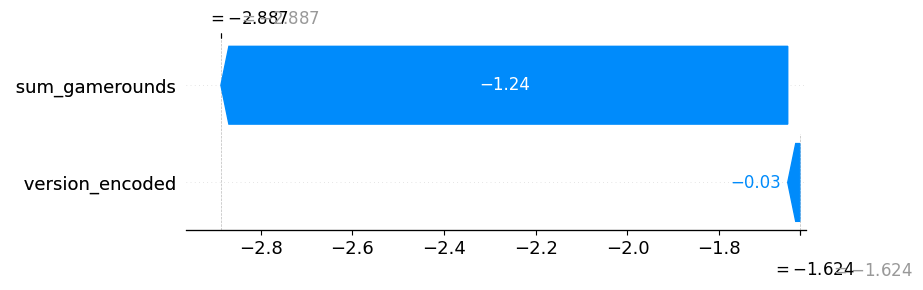

In [47]:
# 💧 SHAP Waterfall Plot for One User (Local Explanation)

# Choose index of the user you want to explain
user_index = 0  # You can change this to any index

# Extract SHAP values and feature row
shap_value = shap_values[user_index]
user_features = X_test.iloc[user_index]

# Generate the SHAP waterfall plot (no plt.figure())
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_value,
    user_features
)

# Save plot manually if needed (must screenshot or use SHAP render)
# SHAP doesn't support saving waterfall directly via matplotlib,
# but you can screenshot it or capture canvas using `save_html` in shap

In [22]:
import math
log_odds = explainer.expected_value + shap_values[0].sum()
prob = 1 / (1 + math.exp(-log_odds))
print(f"Predicted 7-Day Retention Probability: {prob:.2f}")

Predicted 7-Day Retention Probability: 0.05


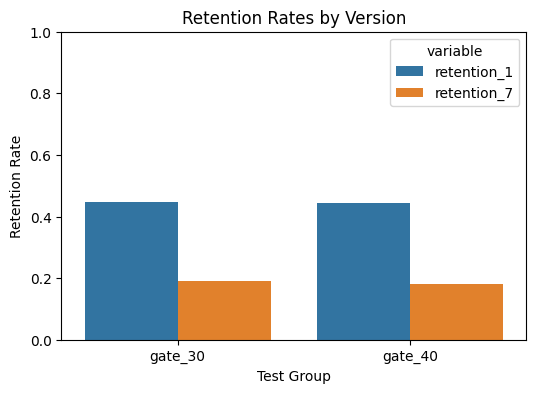

In [23]:
# Group-level retention rates
retention = df.groupby('version')[['retention_1', 'retention_7']].mean().reset_index()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x='version', y='value', hue='variable',
            data=pd.melt(retention, id_vars='version'))
plt.title("Retention Rates by Version")
plt.ylabel("Retention Rate")
plt.xlabel("Test Group")
plt.ylim(0, 1)
plt.show()


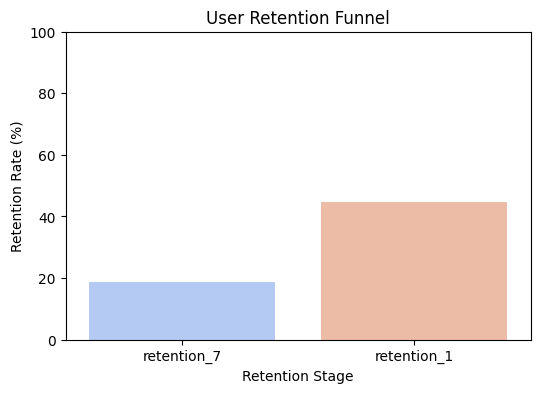

In [27]:
# Retention Funnel Plot (Day 1 to Day 7)
funnel_data = df[['retention_1', 'retention_7']].mean().sort_index(ascending=False) * 100

plt.figure(figsize=(6, 4))
sns.barplot(x=funnel_data.index, y=funnel_data.values, palette='coolwarm')
plt.title("User Retention Funnel")
plt.ylabel("Retention Rate (%)")
plt.xlabel("Retention Stage")
plt.ylim(0, 100)
plt.show()

In [28]:
# Chi-squared results in table format
chi_summary = pd.DataFrame({
    "Group": ["gate_30", "gate_40"],
    "Retained": ab_table[1].values,
    "Not Retained": ab_table[0].values
})
chi_summary["Retention Rate (%)"] = 100 * chi_summary["Retained"] / (chi_summary["Retained"] + chi_summary["Not Retained"])

display(chi_summary)

,Group,Retained,Not Retained,Retention Rate (%)
0,gate_30,8502,36198,19.020134
1,gate_40,8279,37210,18.200004


In [34]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_scores, model_name="Model", threshold=0.5):
    """
    Plots ROC curve and prints evaluation metrics for a binary classifier.

    Parameters:
        y_true: Actual binary labels
        y_scores: Predicted probabilities (not hard labels)
        model_name: Label for plot title
        threshold: Classification threshold (default=0.5)
    """
    # ROC metrics
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    # Hard predictions based on threshold
    y_pred = (y_scores >= threshold).astype(int)

    # Plot ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print core metrics
    print(f"{model_name} Evaluation @ Threshold = {threshold}")
    print(f"Accuracy  : {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision : {precision_score(y_true, y_pred):.3f}")
    print(f"Recall    : {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score  : {f1_score(y_true, y_pred):.3f}")
    print(f"ROC AUC   : {auc_score:.3f}")

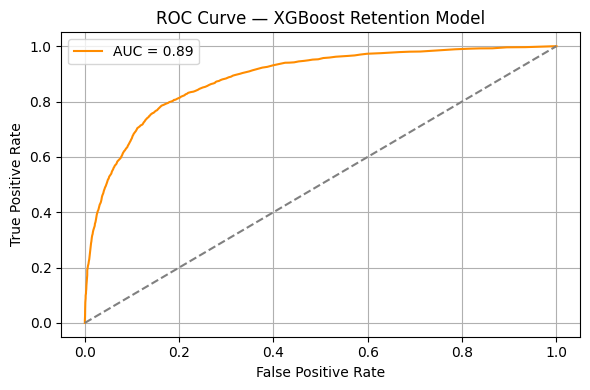

XGBoost Retention Model Evaluation @ Threshold = 0.5
Accuracy  : 0.870
Precision : 0.712
Recall    : 0.506
F1 Score  : 0.592
ROC AUC   : 0.886


In [35]:
evaluate_model(y_test, y_prob, model_name="XGBoost Retention Model", threshold=0.5)

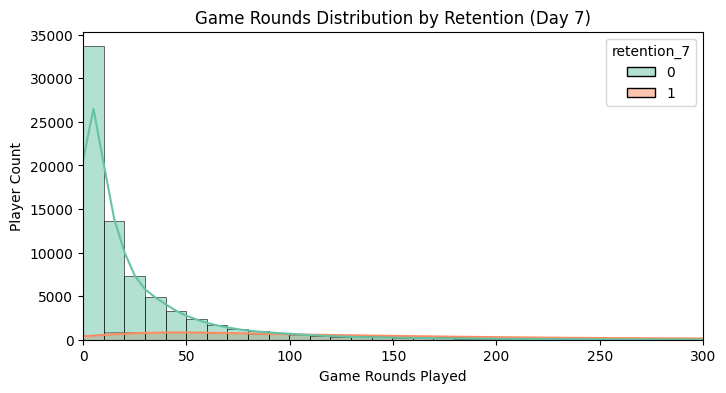

In [30]:
# Remove outliers and visualize
df_plot = df[df['sum_gamerounds'] < 1000]

plt.figure(figsize=(8, 4))
sns.histplot(data=df_plot, x='sum_gamerounds', hue='retention_7', bins=100, kde=True, palette='Set2')
plt.title("Game Rounds Distribution by Retention (Day 7)")
plt.xlabel("Game Rounds Played")
plt.ylabel("Player Count")
plt.xlim(0, 300)
plt.show()

In [31]:
# Quantify impact of behavior
df['engagement_level'] = pd.cut(df['sum_gamerounds'], bins=[0, 5, 20, 50, 1000], labels=['<5', '5-20', '20-50', '50+'])

pop_counts = df['engagement_level'].value_counts().sort_index()
ret_counts = df.groupby('engagement_level')['retention_7'].sum()

ret_impact = pd.DataFrame({
    'Users': pop_counts,
    'Retained': ret_counts,
    'Retention Rate': ret_counts / pop_counts
}).reset_index()

display(ret_impact)

,engagement_level,Users,Retained,Retention Rate
0,<5,20723,284,0.013705
1,5-20,25085,1226,0.048874
2,20-50,17575,2696,0.153400
3,50+,22696,12432,0.547762
